In [4]:
# Imports & OU function

import torch
from typing import Optional

def simulate_ou(
    mu_series: torch.Tensor,
    theta: float,
    sigma: float,
    dt: float
) -> torch.Tensor:
    """
    Simulate an Ornstein–Uhlenbeck process around a time-varying mean series.

    Args:
        mu_series (torch.Tensor): 1-D tensor of length T representing μₜ at each step
        theta (float): speed of mean reversion
        sigma (float): diffusion coefficient (volatility)
        dt (float): time increment size

    Returns:
        torch.Tensor: simulated OU path of length T
    """
    # Convert dt to a tensor once, so torch.sqrt works
    dt_tensor = torch.tensor(dt)
    sqrt_dt = torch.sqrt(dt_tensor)

    T = mu_series.shape[0]
    P = torch.zeros(T)
    P[0] = mu_series[0]

    for t in range(1, T):
        # Mean-reversion drift towards mu_series[t]
        drift = theta * (mu_series[t] - P[t - 1]) * dt
        # Brownian diffusion term using torch.sqrt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t - 1] + drift + diffusion

    return P


In [5]:
# Set parameters & build mu_series
# Common settings
T          = 10_000        # number of time steps
dt         = 1.0 / T       # time increment
mu0        = 50.0          # base mean level
trend_rate = 0.01          # drift per step for trending regimes
regime_len = 500           # steps per regime in switching scenario

# 1) Up‐trending mean
mu_trend = mu0 + trend_rate * torch.arange(T, dtype=torch.float)

# 2) Flat mean (pure mean‐reversion)
mu_flat  = mu0 * torch.ones(T)

# 3) Switching mean (up/down every `regime_len` steps)
mu_switch = torch.zeros(T)
mu_switch[0] = mu0
for t in range(1, T):
    direction = 1 if ((t // regime_len) % 2 == 0) else -1
    mu_switch[t] = mu_switch[t-1] + direction * trend_rate


In [6]:
#Simulate OU processes
# simulate
P_trend  = simulate_ou(mu_trend,  theta=2.0,  sigma=20.0, dt=dt)
P_revert = simulate_ou(mu_flat,   theta=20.0, sigma=50.0, dt=dt)
P_switch = simulate_ou(mu_switch, theta=7.5,  sigma=10.0, dt=dt)

# quick inspect
print("Trend first 5:", P_trend[:5])
print("Revert first 5:", P_revert[:5])
print("Switch first 5:", P_switch[:5])


Trend first 5: tensor([50.0000, 49.8854, 50.0519, 49.9836, 49.7926])
Revert first 5: tensor([50.0000, 49.4072, 49.0026, 49.0861, 48.8789])
Switch first 5: tensor([50.0000, 49.9375, 50.2253, 50.2259, 50.2835])


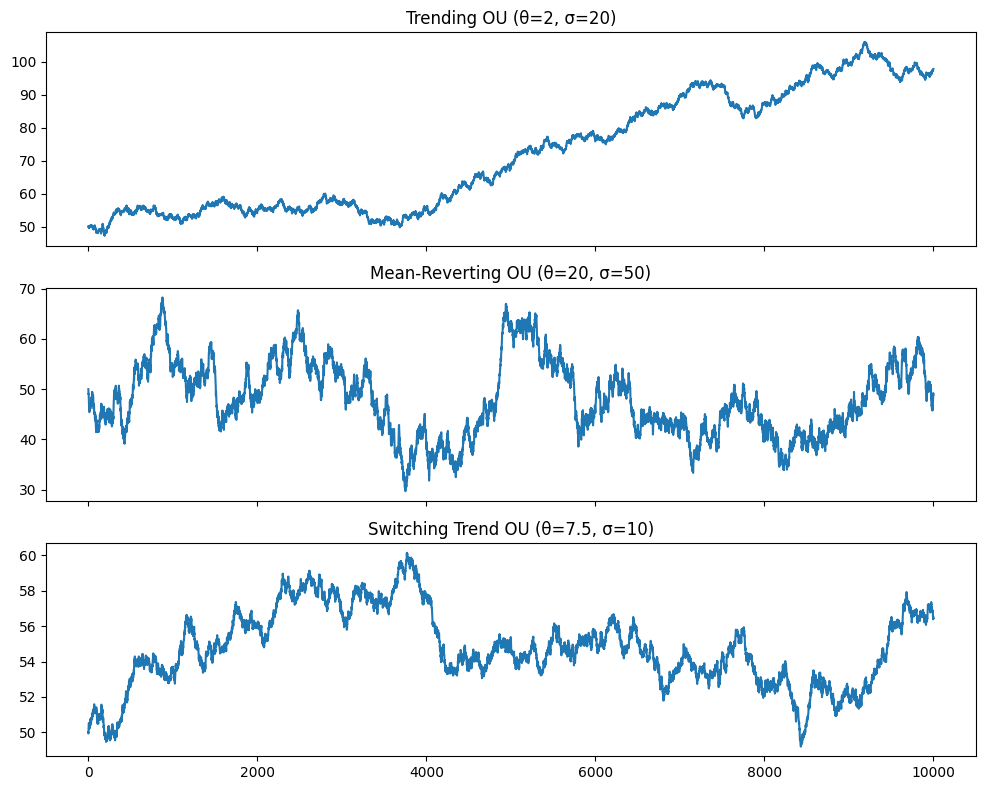

In [7]:
#Plot Results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(P_trend)
axes[0].set_title("Trending OU (θ=2, σ=20)")

axes[1].plot(P_revert)
axes[1].set_title("Mean‐Reverting OU (θ=20, σ=50)")

axes[2].plot(P_switch)
axes[2].set_title("Switching Trend OU (θ=7.5, σ=10)")

plt.tight_layout()
plt.show()
